In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/Users/Work/Developer/interpretDL/Pipeline")

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [81]:
import numpy as np
import pandas as pd
import umap

from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

In [13]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [6]:
fname = "data/hr_lr.csv"
raw_data = pd.read_csv(fname, index_col=0).values
raw_data

array([[443.6580811 , 156.8248444 , 157.2230988 , ...,  32.40001297,
         10.53292751,   1.        ],
       [529.8170776 , 301.1605835 , 129.0924835 , ...,  44.31515884,
         12.01620674,   1.        ],
       [689.3991699 , 303.3375244 , 154.1694336 , ...,  63.73936081,
         10.89778328,   1.        ],
       ...,
       [630.8562622 , 303.7183533 , 210.3960266 , ...,  40.54899216,
         17.80297661,   0.        ],
       [479.3210144 , 263.7200623 , 136.6897278 , ...,  42.96739197,
         12.05090141,   0.        ],
       [767.0294189 , 488.8855896 , 134.025528  , ...,  36.10884857,
         15.40684414,   0.        ]])

In [82]:
X = raw_data[:, :-1]
Y = raw_data[:,-1].reshape(-1,1)
X.shape

(164, 333)

In [83]:
ZScaler = StandardScaler().fit(X)
X = ZScaler.transform(X)

In [64]:
# Function to create model, required for KerasClassifier
def create_model(nodes=12):
    # create model
    model = Sequential()
    model.add(Dense(nodes, input_dim=333, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [65]:
np.logspace(3, 8, num=6, base=2, dtype=int)

array([  8,  16,  32,  64, 128, 256])

In [66]:
%%time
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [20]
num_nodes = [64,100,128]
epochs = [500]
param_grid = dict(batch_size=batch_size, epochs=epochs, nodes=num_nodes)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4, cv=10)
grid_result = grid.fit(X, Y)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



CPU times: user 7.89 s, sys: 1.82 s, total: 9.7 s
Wall time: 52.2 s


In [67]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.597561 using {'batch_size': 20, 'epochs': 500, 'nodes': 128}
0.292683 (0.448668) with: {'batch_size': 20, 'epochs': 500, 'nodes': 64}
0.109756 (0.303304) with: {'batch_size': 20, 'epochs': 500, 'nodes': 100}
0.597561 (0.484526) with: {'batch_size': 20, 'epochs': 500, 'nodes': 128}


In [68]:
# grid.n_splits_

In [69]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(16,8),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
#     axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
#     axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [84]:
dnn = create_model(128)
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               42752     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 129       
Total params: 42,881
Trainable params: 42,881
Non-trainable params: 0
_________________________________________________________________


In [85]:
history = dnn.fit(X,Y, verbose=0, epochs=10, batch_size=20)

In [98]:
from datetime import datetime
datetime.now().strftime("%Y%m%d-%H%M%S")

'20190920-172852'

In [93]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs/new', update_freq='epoch') #{}.format(time)

dnn.fit(X,Y, verbose=0, epochs=100, batch_size=20, callbacks=[tensorboard])

In [253]:
def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    tf.random.set_random_seed(RANDOM_STATE)
    
    reg_scale = 0.01 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)
    
    dnn.add(Dense(units = 150, activation=activation, input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0.2))
    dnn.add(Dense(units = 25, activation=activation,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)
    SGD=keras.optimizers.SGD(lr=0.001)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=SGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [254]:
# dnn = build_dnn(num_features=data.shape[1], num_labels=1)
# dnn.summary()

In [278]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=100,
                                           verbose=2, mode='max', baseline=None, restore_best_weights=True)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)

## Batch size: 10

In [283]:
%%time
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=1000, batch_size=10, verbose=0, callbacks=[])

CPU times: user 34.9 s, sys: 9.14 s, total: 44 s
Wall time: 19 s


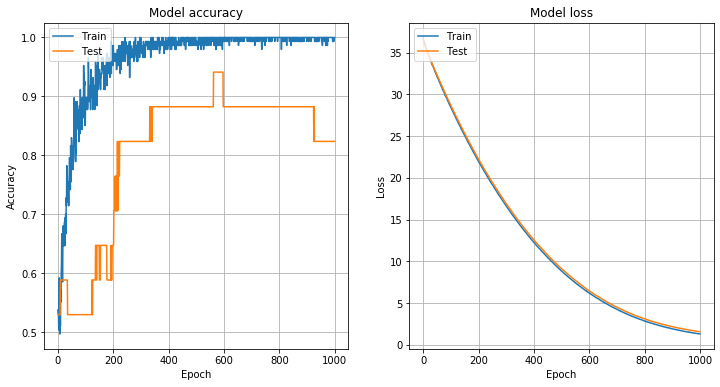

17/17 [==============================] - 0s 56us/step
Loss:1.571, Acc:0.8235


In [284]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))